In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mcap_ros2.reader import read_ros2_messages
import sys
from scipy import signal

# 获取当前 notebook 所在的目录
current_dir = os.getcwd()

# 获取项目根目录 (即当前目录的上一级)
project_root = os.path.abspath(os.path.join(current_dir, ".."))

# 将根目录加入到 Python 的搜索路径中
if project_root not in sys.path:
    sys.path.append(project_root)


from typing import Optional
from core.utils.common import error, info
from core.utils import radardsp as rdsp


from core.config import EL_CFAR_SKIP_BIN, NUMBER_RANGE_BINS_MIN
from core.config import NUMBER_DOPPLER_BINS_MIN
from core.config import NUMBER_AZIMUTH_BINS_MIN
from core.config import NUMBER_ELEVATION_BINS_MIN
from core.config import DOA_METHOD
from core.config import RDSP_METHOD

from core.config import RD_OS_CFAR_WS
from core.config import RD_OS_CFAR_GS
from core.config import RD_OS_CFAR_K
from core.config import RD_OS_CFAR_TOS

from core.config import AZ_OS_CFAR_WS
from core.config import AZ_OS_CFAR_GS
from core.config import AZ_OS_CFAR_TOS

# capon parameters
# from core.config import CAPON_METHOD
from core.config import AZ_BINS_NUM, EL_BINS_NUM, ANGLE_RES_EL, ANGLE_RES_AZ, AZ_MAX, EL_MAX, AZ_MESH, EL_MESH

from core.config import RA_OS_CFAR_WS
from core.config import RA_OS_CFAR_GS
from core.config import RA_OS_CFAR_K
from core.config import RA_OS_CFAR_TOS

from core.config import EL_OS_CFAR_WS
from core.config import EL_OS_CFAR_GS
from core.config import EL_OS_CFAR_TOS

# CFAR skip bin
from core.config import CFAR_SKIP_RANGE_BIN_NEAR, CFAR_SKIP_RANGE_BIN_FAR, CFAR_SKIP_AZIMUTH_BIN


import core.dsp as dsp
# Azimuth angle range
# AZIMUTH_FOV: float = np.deg2rad(180)
# # Elevation angle range
# ELEVATION_FOV: float = np.deg2rad(20)

def convert_to_complex_cube(data: np.ndarray, num_chirps: int, num_rx: int, 
                                  num_samples: int, is_complex: bool, interleaved: bool) -> np.ndarray:
        """
        Convert raw int16 data to standardized complex64 radar cube.
        
        Args:
            data: Raw int16 array of ADC samples
            num_chirps: Number of chirps in frame
            num_rx: Number of RX antennas
            num_samples: Number of ADC samples per chirp
            is_complex: True for I/Q complex data, false for real-only
            interleaved: True for interleaved format (IIQQ), false for non-interleaved
            
        Returns:
            Complex64 array with shape [num_chirps, num_rx, num_samples]
            
        Raises:
            ValueError: If data length doesn't match expected dimensions
        """
        # Calculate expected data length
        C = 2 if is_complex else 1
        expected_length = num_chirps * num_rx * num_samples * C
        
        # Validate data length
        if len(data) != expected_length:
            raise ValueError(
                f"Data length mismatch: expected {expected_length}, got {len(data)}. "
                f"Dimensions: chirps={num_chirps}, rx={num_rx}, samples={num_samples}, "
                f"is_complex={is_complex}"
            )
        
        # Handle different data formats
        if not is_complex:
            # Real data: simple reshape to [chirps, rx, samples], then convert to complex
            cube = data.reshape(num_chirps, num_rx, num_samples)
            # Convert to complex (imaginary part = 0)
            cube = cube.astype(np.complex64)
        else:
            # Complex data: extract I and Q components
            if interleaved:
                # IIQQ format: DCA1000 2-lane LVDS interleaved data format
                # Data layout: [Q0, Q1, I0, I1, Q2, Q3, I2, I3, ...]
                # Reshape to [num_chirps, num_rx, num_samples * 2] to expose the interleaved dimension
                iiqq = data.reshape(num_chirps, num_rx, num_samples * 2)
                
                # De-interleave IIQQ format to reconstruct complex samples:
                # For even sample indices (0, 2, 4, ...): Q from position 0, I from position 2
                # For odd sample indices (1, 3, 5, ...): Q from position 1, I from position 3
                cube = np.zeros((num_chirps, num_rx, num_samples), dtype=np.complex64)
                cube[:, :, 0::2] = 1j * iiqq[:, :, 0::4].astype(np.float32) + iiqq[:, :, 2::4].astype(np.float32)
                cube[:, :, 1::2] = 1j * iiqq[:, :, 1::4].astype(np.float32) + iiqq[:, :, 3::4].astype(np.float32)
            else:
                # Non-interleaved format: [I0, I1, ..., Q0, Q1, ...]
                half = len(data) // 2
                I = data[:half].reshape(num_chirps, num_rx, num_samples)
                Q = data[half:].reshape(num_chirps, num_rx, num_samples)
                cube = I.astype(np.float32) + 1j * Q.astype(np.float32)
                cube = cube.astype(np.complex64)
        
        return cube


def fft_with_shift(data: np.ndarray, axes: tuple, size: tuple = None, shift: tuple = None) -> np.ndarray:
    """
    Compute FFT along specified axes with zero-padding and optional fftshift.
    Optimized to avoid unnecessary copies.
    
    Args:
        data: Input data
        axes: Axes along which to compute FFT
        size: Target size for each axis (for zero-padding), must match axes length
        shift: Axes to shift after FFT (if None, no shift).
                - For range-doppler: shift=(1,) shifts doppler axis only, keeping range 0 at index 0
                - For elevation-azimuth: shift=(2, 3) shifts both elevation and azimuth axes
    """
    result = data  # Don't copy unless we need to modify
    
    if size is not None:
        # Zero-pad if needed - only copy if modification is needed
        needs_copy = False
        for axis, target_size in zip(axes, size):
            if target_size != result.shape[axis]:
                needs_copy = True
                break
        
        if needs_copy:
            result = result.copy()  # Only copy if we need to modify
            for axis, target_size in zip(axes, size):
                if target_size > result.shape[axis]:
                    pad_shape = list(result.shape)
                    pad_shape[axis] = target_size - result.shape[axis]
                    pad = np.zeros(pad_shape, dtype=result.dtype)
                    result = np.concatenate([result, pad], axis=axis)
                elif target_size < result.shape[axis]:
                    # Truncate
                    slices = [slice(None)] * result.ndim
                    slices[axis] = slice(0, target_size)
                    result = result[tuple(slices)]
    
    # Compute FFT along each axis (in-place when possible)
    for axis in axes:
        result = np.fft.fft(result, axis=axis)
    
    # Apply fftshift only to specified axes
    if shift is not None:
        result = np.fft.fftshift(result, axes=shift)
    
    return result




def construct_virtual_array(rd: np.ndarray) -> np.ndarray:
    """
    Construct TDM-MIMO virtual array from range-doppler spectrum.
    
    This function maps physical TX-RX antenna pairs to a virtual array geometry
    optimized for elevation and azimuth angle estimation. The virtual array is
    constructed based on the TDM-MIMO chirp sequence and antenna spacing.
    
    Args:
        rd: Range-doppler spectrum with shape [batch, doppler, tx, rx, range]
            where tx=3, rx=4 for AWR1843Boost
            
    Returns:
        MIMO virtual array with shape [batch, doppler, elevation, azimuth, range]
        where elevation=2, azimuth=8
        
    Virtual Array Geometry:
        The virtual array organizes antenna data into elevation and azimuth dimensions
        based on the physical antenna layout and TDM-MIMO chirp sequence:
        - Elevation row 0: Uses TX3 data (positions 2-5) for elevation estimation
        - Azimuth row 1: Uses TX1 data (positions 0-3) and TX2 data (positions 4-7) for azimuth estimation
        
    Note:
        This mapping is specific to AWR1843Boost antenna configuration with 3 TX and 4 RX antennas.
    """
    batch, doppler, tx, rx, range_bins = rd.shape
    if tx != 3 or rx != 4:
        raise ValueError(f"Expected (tx, rx)=(3, 4), got tx={tx} and rx={rx}.")
    
    mimo = np.zeros((batch, doppler, 2, 8, range_bins), dtype=np.complex64)
    # Map TX3 to elevation row 0 (positions 2-5)
    mimo[:, :, 0, 2:6, :] = rd[:, :, 1, :, :]
    # Map TX1 to azimuth row 1 (positions 0-3)
    mimo[:, :, 1, 0:4, :] = rd[:, :, 0, :, :]
    # Map TX2 to azimuth row 1 (positions 4-7)
    mimo[:, :, 1, 4:8, :] = rd[:, :, 2, :, :]
    return mimo

# ==========================================
# 1. 笛卡尔坐标转换工具函数 (对应 signal_processor.py)
# ==========================================

def convert_to_cartesian_xy(ra_2d, range_max, azimuth_bins):
    """
    将 Range-Azimuth 热图转换为笛卡尔 XY (俯视图)
    物理单位: 米 (Meters)
    """
    range_bins, _ = ra_2d.shape
    grid_res = 0.1  # 网格分辨率 0.1m
    max_dist = 100.0 # 最大显示范围
    
    # 限制显示范围不超过最大探测距离
    max_xy = min(range_max, max_dist) if range_max > 0 else max_dist
    
    # 构建极坐标网格
    # 方位角范围: -90 到 +90 度
    azimuth_angles = np.linspace(-np.pi/2, np.pi/2, azimuth_bins).astype(np.float32)
    range_values = np.linspace(0, range_max, range_bins).astype(np.float32)
    
    # 构建笛卡尔网格 (输出图像的坐标轴)
    # X轴: 左右方向 (Lateral), Y轴: 前方方向 (Longitudinal)
    x_coords = np.arange(-max_xy, max_xy + grid_res, grid_res).astype(np.float32)
    y_coords = np.arange(0, max_xy + grid_res, grid_res).astype(np.float32)
    
    # 初始化输出图像 [Height(Y), Width(X)]
    cartesian_xy = np.zeros((len(y_coords), len(x_coords)), dtype=np.float32)
    
    # 简单的最近邻插值映射 (Python 循环较慢，仅作演示，实际可用 cv2.remap 加速)
    # 为了速度，这里使用简化的向量化掩码或直接遍历（数据量不大时可行）
    # 这里为了代码清晰且不依赖 opencv，使用双重循环的优化版逻辑
    
    # 预计算 r, a 的 sin/cos
    R, A = np.meshgrid(range_values, azimuth_angles, indexing='ij')
    X_polar = R * np.sin(A)
    Y_polar = R * np.cos(A)
    
    # 展平以便处理
    flat_x = X_polar.flatten()
    flat_y = Y_polar.flatten()
    flat_val = ra_2d.flatten()
    
    # 过滤掉超出范围的点
    mask = (np.abs(flat_x) <= max_xy) & (flat_y >= 0) & (flat_y <= max_xy)
    valid_x = flat_x[mask]
    valid_y = flat_y[mask]
    valid_val = flat_val[mask]
    
    # 映射到网格索引
    # x_idx = (x - x_min) / res
    x_indices = ((valid_x - x_coords[0]) / grid_res).astype(int)
    y_indices = ((valid_y - y_coords[0]) / grid_res).astype(int)
    
    # 边界检查
    valid_indices = (x_indices >= 0) & (x_indices < len(x_coords)) & \
                    (y_indices >= 0) & (y_indices < len(y_coords))
    
    # 填充 (取最大值策略，避免覆盖)
    # 注意：这种散点填充在 Python 中如果不使用 Numba 比较慢，
    # 实际应用中建议使用 scipy.interpolate.griddata 或 cv2
    # 这里为了简便和保持与 signal_processor.py 逻辑一致，采用累积最大值
    for x_idx, y_idx, val in zip(x_indices[valid_indices], y_indices[valid_indices], valid_val[valid_indices]):
        if val > cartesian_xy[y_idx, x_idx]:
            cartesian_xy[y_idx, x_idx] = val
            
    return cartesian_xy, (-max_xy, max_xy, 0, max_xy) # 返回数据和物理范围 extent

def convert_to_cartesian_xz(re_2d, range_max, elevation_bins=None):
    """
    将 Range-Elevation 热图转换为笛卡尔 XZ (侧视图)
    物理单位: 米 (Meters)

    修正说明:
    - 有时调用处传入的 elevation_bins 与 re_2d 的列数不一致（会导致 boolean mask 尺寸不匹配）。
    - 这里优先使用 re_2d 的实际列数（即 elevation bins），除非显式传入并与之匹配。
    """
    # re_2d shape: (range_bins, elevation_bins_actual)
    range_bins, elevation_bins_actual = re_2d.shape
    if elevation_bins is None:
        elevation_bins = elevation_bins_actual
    else:
        # 如果传入的 elevation_bins 与数据不匹配，覆盖并使用数据本身的列数
        if elevation_bins != elevation_bins_actual:
            elevation_bins = elevation_bins_actual

    grid_res = 0.1
    max_x = min(range_max, 100.0)
    max_z = 15.0  # 高度范围通常较小，设为 +/- 15米

    # 假设俯仰角范围: -30 到 +30 度 (AWR1843Boost 典型值)
    elevation_max_deg = 30.0
    elevation_angles = np.linspace(
        np.deg2rad(-elevation_max_deg),
        np.deg2rad(elevation_max_deg),
        elevation_bins
    ).astype(np.float32)
    range_values = np.linspace(0, range_max, range_bins).astype(np.float32)

    # 网格: X (距离), Z (高度)
    x_coords = np.arange(0, max_x + grid_res, grid_res)
    z_coords = np.arange(-max_z, max_z + grid_res, grid_res)

    cartesian_xz = np.zeros((len(z_coords), len(x_coords)), dtype=np.float32)

    # 向量化映射
    R, E = np.meshgrid(range_values, elevation_angles, indexing='ij')
    X_polar = R * np.cos(E)
    Z_polar = R * np.sin(E)

    flat_x = X_polar.flatten()
    flat_z = Z_polar.flatten()
    flat_val = re_2d.flatten()

    # 此处保证 flat_val 与 flat_x/flat_z 长度一致
    if flat_val.size != flat_x.size:
        # 在非常规情况下尝试修复维度：reshape 或重复/裁剪都不安全，因此抛出更明确的错误
        raise ValueError(f"re_2d flatten size ({flat_val.size}) does not match expected "
                         f"polar mapping size ({flat_x.size}). Check re_2d shape and elevation bins.")

    mask = (flat_x >= 0) & (flat_x <= max_x) & (np.abs(flat_z) <= max_z)

    x_indices = ((flat_x[mask] - x_coords[0]) / grid_res).astype(int)
    z_indices = ((flat_z[mask] - z_coords[0]) / grid_res).astype(int)

    valid = (x_indices >= 0) & (x_indices < len(x_coords)) & \
            (z_indices >= 0) & (z_indices < len(z_coords))

    for x_idx, z_idx, val in zip(x_indices[valid], z_indices[valid], flat_val[mask][valid]):
        if val > cartesian_xz[z_idx, x_idx]:
            cartesian_xz[z_idx, x_idx] = val

    return cartesian_xz, (0, max_x, -max_z, max_z)  # extent: [left, right, bottom, top]

def get_coupling_matrix(path: str) -> np.ndarray:
    """Get the coupling matrix for calibration.

    Return:
        The coupling matrix with shape of
        (coupling_num_tx, coupling_num_rx, num_samples_per_chirp)
    """

    with open(path, "r") as fh:
        for line in fh:
            if line.startswith("# "):
                continue
            else:
                chunks = line.strip().split(" ")
                if chunks[0] == "num_tx":
                    coupling_num_tx = int(chunks[1])
                elif chunks[0] == "num_rx":
                    coupling_num_rx = int(chunks[1])
                elif chunks[0] == "data":
                    coupling_data = np.array(
                        [float(val) for val in chunks[1:]],
                        dtype=np.float32,
                    )
    return coupling_num_tx, coupling_num_rx, coupling_data
def get_antenna_layout(path: str) -> tuple[np.ndarray, np.ndarray, float]:
    rxl = []
    txl = []
    with open(path, "r") as fh:
        for line in fh:
            if line.startswith("# "):
                continue
            else:
                chunks = line.strip().split(" ")
                if chunks[0] == "rx":
                    rxl.append([int(x) for x in chunks[1:]])
                elif chunks[0] == "tx":
                    txl.append([int(x) for x in chunks[1:]])
                elif chunks[0] == "F_design":
                    F_design = float(chunks[1])
    return np.array(rxl), np.array(txl), F_design



# polar: bool = False, show: bool = True, method: str = "Capon"
#     ) -> None:
"""
    Process the raw ADC samples and render the 2D Range-Azimuth map.
    following the pipeline:
        1. Calibrate the raw ADC samples
        2. Apply the Range FFT processing +  beamforming method
        3. Render the 2D Range-Azimuth map

    Arguments:
        method: Beamforming method to use. Default is Capon
"""

def dc_remove(data: np.array) -> np.array:
    """Handle the calibration of raw ADC samples.

    Return:
        Remove DC bias of the radar sensor

    NOTE: Only the casacde chip radar sensor has the frequency and phase
    calibration
    """
    if data is None:
        exit(1)
    adc_samples = data

    # Remove DC bias
    # adc_samples -= np.mean(adc_samples)
    adc_samples_sc = adc_samples
    dc3_sc = np.mean(adc_samples_sc, axis=3)
    adc_samples = adc_samples_sc - dc3_sc[:,:,:,np.newaxis]

    return adc_samples


def get_fft_size(ne: Optional[int], na: Optional[int],
             nc: Optional[int], ns: Optional[int]) -> tuple[int, int, int, int]:
        """Get optimal FFT size.

        Arguments:
            ne: Size of the elevation axis of the data cube
            na: Size of the azimuth axis of the data cube
            nc: Number of chirp loops
            ns: Number of samples per chirp

        Return:
            Tuple of the optimal size of each parameter provided in argument
            in the exact same order.
        """
        # Estimated size of the elevation and azimuth
        if ne is not None:
            ne = rdsp.fft_size(ne)
            ne = (
                ne if ne > NUMBER_ELEVATION_BINS_MIN else NUMBER_ELEVATION_BINS_MIN
            )

        if na is not None:
            na = rdsp.fft_size(na)
            na = na if na > NUMBER_AZIMUTH_BINS_MIN else NUMBER_AZIMUTH_BINS_MIN

        if nc is not None:
            # Size of doppler FFT
            nc = rdsp.fft_size(nc)
            nc = nc if nc > NUMBER_DOPPLER_BINS_MIN else NUMBER_DOPPLER_BINS_MIN
        if ns is not None:
            # Size of range FFT
            ns = rdsp.fft_size(ns)
            ns = ns if ns > NUMBER_RANGE_BINS_MIN else NUMBER_RANGE_BINS_MIN

        return ne, na, nc, ns




def pre_process(adc_samples: np.array, apply_padding: bool = True) -> tuple[np.array, np.array]:
        """Pre processing of ADC samples.

        The pre-processing step helps in reshaping the data so to match
        the antenna layout of the radar sensor. Some paddings are also
        added if required in order to have a minimum of pre-defined
        frequency bins during FFT processing.

        Since the number of antenna and device configuration can vary
        from one board or recording to another,
        it's good to define a minimum size for the doppler, azimuth, and
        elevation FFT processing (See `config.py` for the default values).

        This does not affect the resolution of the radar sensor but only
        the 3D rendeing.

        Argument:
            adc_samples: Calibrated ADC samples

        Return (tuple):
            virtual_array: 4D data cube ready for FFT processing
        """



        global virtual_array
        virtual_array = rdsp.virtual_array(
            adc_samples,
            calibration_antenna_txl,
            calibration_antenna_rxl,
        )

        # va_nel: Number of elevations in the virtual array
        # va_naz: Number of azimuth in the virtual array
        # va_nc: Number of chirp per antenna in the virtual array
        # va_ns: Number of samples per chirp
        va_nel, va_naz, va_nc, va_ns = virtual_array.shape # (2, 8, 128, 128)

        Ne, Na, Nc, Ns = get_fft_size(*virtual_array.shape)
        if apply_padding:
            virtual_array = np.pad(
                virtual_array,
                (
                    (0, Ne - va_nel), (0, Na - va_naz),
                    (0, Nc - va_nc), (0, Ns - va_ns)
                ),
                "constant",
                constant_values=((0, 0), (0, 0), (0, 0), (0, 0))
            )
        return virtual_array


def get_coupling_calibration(path: str, wf_num_adc_samples_per_chirp: int) -> np.array:
    """Return the coupling calibration array to apply on the range fft."""

    with open(path, "r") as fh:
        for line in fh:
            if line.startswith("# "):
                continue
            else:
                chunks = line.strip().split(" ")
                if chunks[0] == "num_tx":
                    coupling_num_tx = int(chunks[1])
                elif chunks[0] == "num_rx":
                    coupling_num_rx = int(chunks[1])
                elif chunks[0] == "data":
                    coupling_data = np.array(
                        [float(val) for val in chunks[1:]],
                        dtype=np.float32,
                    )
    return np.array(coupling_data).reshape(
        coupling_num_tx,
        coupling_num_rx,
        1,
        wf_num_adc_samples_per_chirp,
    )


def get_bins(ns: Optional[int], nc: Optional[int]) ->tuple[np.array, np.array, np.array, np.array]:
    """Return the range, velocity, azimuth and elevation bins.

    Arguments:
        ne: Elevation FFT size
        na: Azimuth FFT size
        nc: Doppler FFT size
        ns: Range FFT size

    Return:
        range bins
        velocity bins
        azimuth bins
        elevation bins

    NOTE: The bins are returned in the order listed above
    """


    rbins = np.array([])        # Range bins
    vbins = np.array([])        # Doppler bins
    abins = np.array([])        # Azimuth bins
    ebins = np.array([])        # Elevation bins

    if ns:
        rbins = rdsp.get_range_bins(ns, wf_adc_sample_frequency, wf_frequency_slope)

    if nc:
        # Velocity bins
        vbins = rdsp.get_velocity_bins(wf_num_tx, nc, wf_start_frequency, chirp_time)

    # if na:
    #     # Azimuth bins
    #     ares = 2 * AZIMUTH_FOV / na
    #     # Estimate azimuth angles and flip the azimuth axis
    #     abins = -1 * np.arcsin(
    #         np.arange(-AZIMUTH_FOV, AZIMUTH_FOV, ares) / (
    #             2 * np.pi * calibration_d
    #         )
    #     )

    # if ne:
    #     # Elevation
    #     eres = 2 * ELEVATION_FOV / ne
    #     # Estimate elevation angles and flip the elevation axis
    #     ebins = -1 * np.arcsin(
    #         np.arange(-ELEVATION_FOV, ELEVATION_FOV, eres) / (
    #             2 * np.pi * calibration_d
    #         )
    #     )
    # return rbins, vbins, abins, ebins
    # return rbins, None, None, None
    return rbins, vbins


def to_cartesian(hmap: np.array) -> np.array:
        """Convert polar coordinate heatmap to catesian coordinate.

        Argument:
            hmap: The heatmap of shape (-1, 5)
                  Structure (columns):
                    [0]: Azimuth
                    [1]: Range
                    [2]: Elevation
                    [3]: Velocity
                    [4]: Intensity of reflection in dB

                @see: showHeatmapFromRaw

        Example:
            self._to_cartesian(hmap)
        """
        # Ensure 'hmap' is at least 2D
        hmap = np.atleast_2d(hmap)

        if hmap.size == 0 or hmap.shape[1] < 4:
            print("Empty or invalid 'hmap' array. No operations performed.")
            return hmap

        # Initialize 'pcld' based on the shape of 'hmap'
        # pcld = np.zeros((hmap.shape[0], max(4, hmap.shape[1])))  # Ensure pcld has at least 4 columns

        pcld = np.zeros(hmap.shape)
        pcld[:, 0] = hmap[:, 1] * np.cos(hmap[:, 2]) * np.sin(hmap[:, 0])
        pcld[:, 1] = hmap[:, 1] * np.cos(hmap[:, 2]) * np.cos(hmap[:, 0])
        pcld[:, 2] = hmap[:, 1] * np.sin(hmap[:, 2])
        pcld[:, 3:] = hmap[:, 3:]

        ## swap the xy coordinates
        pcld[:, 0], pcld[:, 1] = pcld[:, 1], pcld[:, 0].copy()
        pcld[:, 1] = -pcld[:, 1]

        return pcld

def get_waveform_config(path_waveform_cfg) -> tuple:
    """Return the waveform configuration as a dictionary."""
    with open(path_waveform_cfg, "r") as fh:
        for line in fh:
            if line.startswith("# "):
                continue
            else:
                chunks = line.strip().split(" ")
                if chunks[0] == "num_tx":
                    wf_num_tx = int(chunks[1])
                elif chunks[0] == "num_rx":
                    wf_num_rx = int(chunks[1])
                elif chunks[0] == "num_adc_samples_per_chirp":
                    wf_num_chirps_per_frame = int(chunks[1])
                elif chunks[0] == "num_chirps_per_frame":
                    wf_num_adc_samples_per_chirp = int(chunks[1])
                elif chunks[0] == "adc_sample_frequency":
                    wf_adc_sample_frequency = int(chunks[1])     
                elif chunks[0] == "start_frequency":
                    wf_start_frequency = float(chunks[1])
                elif chunks[0] == "idle_time":
                    wf_idle_time = float(chunks[1])
                elif chunks[0] == "adc_start_time":
                    wf_adc_start_time = float(chunks[1])
                elif chunks[0] == "ramp_end_time":
                    wf_ramp_end_time = float(chunks[1])
                elif chunks[0] == "frequency_slope":
                    wf_frequency_slope = float(chunks[1])
    return tuple([wf_num_tx, wf_num_rx, wf_num_chirps_per_frame, wf_num_adc_samples_per_chirp,
                  wf_adc_sample_frequency, wf_start_frequency, wf_idle_time, wf_adc_start_time,
                  wf_ramp_end_time, wf_frequency_slope])

## Step 2: Data loading and pre-proocessing

### Loading .mcap

In [2]:
radar_messages = []
radar_timestamps = []
radar_cfg = None
target_loc = []
target_loc_timestamp = []
sample_mcap = '/home/zcy/Downloads/2026_01_28_drone_mmwave/moving_staticR_s128_c128_03/moving_staticR_s128_c128_03.mcap'

# read_ros2_messages 返回的是一个生成器(generator)，不能直接调用 .data
# 需要遍历它来获取消息
# topics 参数通常接受一个列表
target_topics = ["/radar_0/raw_data", "/radar_0/info", "/yolo/drone_pose"]

# 3. 循环读取并分类存储
for mcap_msg in read_ros2_messages(str(sample_mcap), topics=target_topics):
    # 获取当前消息的 topic 名称
    topic = mcap_msg.channel.topic
    radar_timestamps.append(mcap_msg.log_time_ns)
    if topic == "/radar_0/raw_data":
        radar_messages.append(mcap_msg.ros_msg)
        radar_timestamps.append(mcap_msg.log_time_ns)

    elif topic == "/radar_0/info":
        radar_cfg = mcap_msg.ros_msg
        radar_cfg_timestamp = mcap_msg.log_time_ns
        
    elif topic == "/yolo/drone_pose":
        target_loc.append(mcap_msg.ros_msg)
        target_loc_timestamp.append(mcap_msg.log_time_ns)

print(f"Successfully loaded {len(radar_messages)} messages.")

if len(radar_messages) > 0:
    # 验证第一帧数据
    print(f"First message data type: {type(radar_messages[0])}")
    # 如果你想看数据，应该看列表中的第一个元素
    # print(radar_messages[0].data)
else:
    print("Warning: No messages found for topic '/radar_0/raw_data'")

    # Parameters extracted from .cfg file:
# profileCfg 0 77 110 4.0 56.0 0 0 70 1 256 5209 0 0 30
# wf_start_frequency = 77e9          # 77 GHz
# wf_idle_time = 200e-6              # 200 us
# wf_adc_start_time = 5.7e-6         # 4.0 us
# wf_ramp_end_time = 59.0e-6         # 56.0 us
# wf_frequency_slope = 67.012e12         # 67.012 MHz/us
# wf_num_adc_samples_per_chirp = 128 # 128 samples
# wf_adc_sample_frequency = 2500e3   # 2500 ksps -> 2.5 MHz
# wf_num_tx = 3                     # 3 TX antennas
# wf_num_rx = 4                     # 4 RX antennas
# # frameCfg 0 2 16 0 33.333 1 0
# wf_num_chirps_per_frame = 384       # numLoops = 16
# tdm_mimo = True  # Assuming TDM-MIMO is enabled



Successfully loaded 159 messages.
First message data type: <class 'mcap_ros2._dynamic.RadarFrame'>


In [3]:
try:
    # 解析 radar_cfg 获取参数
    wf_start_frequency = radar_cfg.config.start_frequency_hz          # 77 GHz
    wf_idle_time = radar_cfg.config.idle_time_us*1e-6              # 110 us
    wf_adc_start_time = radar_cfg.config.adc_start_time_us*1e-6         # 4.0 us
    wf_ramp_end_time = radar_cfg.config.ramp_end_time_us*1e-6         # 56.0 us
    wf_frequency_slope = radar_cfg.config.frequency_slope*1e12         # 70 MHz/us
    wf_num_adc_samples_per_chirp = radar_cfg.config.num_samples # 128 samples
    wf_adc_sample_frequency = radar_cfg.config.sample_rate_hz   # 5209 ksps -> 5.209 MHz
    wf_num_tx = 3                     # 3 TX antennas
    wf_num_rx = radar_cfg.config.num_active_rx                     # 4 RX antennas
    # frameCfg 0 2 16 0 33.333 1 0
    wf_num_chirps_per_frame = radar_cfg.config.num_chirps       # numLoops = 16
    tdm_mimo = radar_cfg.config.tdm_mimo  # Assuming TDM-MIMO is enabled
except:
    print("Warning: Failed to parse radar configuration, using default parameters.")
    wf_start_frequency = 77e9          # 77 GHz
    wf_idle_time = 200e-6              # 200 us
    wf_adc_start_time = 5.7e-6         # 4.0 us
    wf_ramp_end_time = 59.0e-6         # 56.0 us
    wf_frequency_slope = 67.012e12         # 67.012 MHz/us
    wf_num_adc_samples_per_chirp = 128 # 128 samples
    wf_adc_sample_frequency = 2500e3   # 2500 ksps -> 2.5 MHz
    wf_num_tx = 3                     # 3 TX antennas
    wf_num_rx = 4                     # 4 RX antennas
    # frameCfg 0 2 16 0 33.333 1 0
    wf_num_chirps_per_frame = 384       # numLoops = 16
    tdm_mimo = True  # Assuming TDM-MIMO is enabled

In [4]:
print(wf_start_frequency, wf_idle_time, wf_adc_start_time, wf_ramp_end_time, wf_frequency_slope,
      wf_num_adc_samples_per_chirp, wf_adc_sample_frequency, wf_num_tx, wf_num_rx, wf_num_chirps_per_frame)

77000000000.0 0.00019999999999999998 5.699999809265137e-06 5.9e-05 67012001037597.66 128 2500000.0 3 4 384


In [5]:
frame_idx = 110  # 选择要处理的帧索引
data = np.array(radar_messages[frame_idx].data, dtype=np.int16)
cube = convert_to_complex_cube(
    data, wf_num_chirps_per_frame, wf_num_rx, wf_num_adc_samples_per_chirp,
    is_complex = True, interleaved = True
)
# cube shape: [num_chirps, num_rx, num_samples]

# 2. Reshape to TDM structure: [loops, tx, rx, samples]
# For TDM-MIMO, chirps are interleaved by TX: TX1, TX2, TX3, TX1, TX2, TX3, ...
# So we reshape to [loops, tx, rx, samples] where loops = num_chirps / num_tx
if tdm_mimo:
    n_loops = wf_num_chirps_per_frame // wf_num_tx
    if wf_num_chirps_per_frame % wf_num_rx != 0:
        raise ValueError(f"num_chirps ({wf_num_chirps_per_frame}) must be divisible by num_tx ({wf_num_tx})")
    
    # Reshape: [num_chirps, num_rx, num_samples] -> [loops, tx, rx, samples]
    # The chirps are in order: TX0, TX1, TX2, TX0, TX1, TX2, ...
    tdm_cube = cube.reshape(n_loops, wf_num_tx, wf_num_rx, wf_num_adc_samples_per_chirp)
else:
    # Non-TDM-MIMO: keep as [chirps, rx, samples]
    # Add dummy TX dimension for consistency: [chirps, 1, rx, samples]
    tdm_cube = cube[:, None, :, :]
    n_loops = wf_num_chirps_per_frame
    
# 3. Add batch dimension: [1, loops, tx, rx, samples]
# Process each frame independently (no buffering/concatenation)
iq = tdm_cube[None, ...]
# iq shape: [1, loops, tx, rx, samples]
processing_cube = iq
batch, doppler, tx, rx, samples = processing_cube.shape

# 4. Apply Range-Doppler FFT (along doppler=axis 1, range=axis 4)
# Shift only doppler axis to center zero-velocity, keep range 0 at index 0
# This preserves the physical meaning of range bins (0 = closest to radar)
rd = fft_with_shift(processing_cube, axes=(1, 4), shift=(1,))
# rd shape: [batch, doppler, tx, rx, range]

# 5. Construct virtual array from physical antenna data
# For TDM-MIMO: Maps 3 TX × 4 RX physical antennas to 2 elevation × 8 azimuth virtual array
# For non-TDM-MIMO: Use simple virtual array (1 elevation, num_rx azimuth)
if tdm_mimo:
    mimo = construct_virtual_array(rd)
else:
    # Non-TDM-MIMO: simple virtual array (no elevation/azimuth separation)
    # Use first TX antenna data (or all TX if only one)
    batch, doppler, tx, rx, range_bins = rd.shape
    # For non-TDM-MIMO, we typically have only one TX active
    # Create virtual array: [batch, doppler, 1, rx, range]
    mimo = rd[:, :, 0:1, :, :]  # Use first TX only
    # Reshape to match expected shape [batch, doppler, elevation, azimuth, range]
    # Add elevation dimension: [batch, doppler, 1, rx, range]
    mimo = mimo.reshape(batch, doppler, 1, rx, range_bins)
# mimo shape: [batch, doppler, elevation, azimuth, range]

# 6. Apply Elevation-Azimuth FFT (along elevation=axis 2, azimuth=axis 3)
# Zero-pad azimuth dimension to 128 for higher angular resolution
# Shift both elevation and azimuth axes to center zero-angle
azimuth_size = 128  # Target azimuth resolution
elevation_size = mimo.shape[2]  # Keep original elevation size

raw = np.transpose(tdm_cube, (1, 2, 0, 3))  # [batch, loops, rx, tx, samples]
raw.shape


(3, 4, 128, 128)

In [26]:
path_antenna_cfg = "../dataset/calib/single_chip/antenna_cfg.txt"
path_waveform_cfg = "../dataset/calib/single_chip/waveform_cfg.txt"
path_coulping_calib = "../dataset/calib/single_chip/coupling_calib.txt"

method = 'Capon' # 'Bartlett' or 'Capon'

'''Coloradar OS-CFAR Flag'''
EN_coloradar_CFAR = False


# Layout configuration of the antenna and designed frequency
calibration_antenna_rxl, calibration_antenna_txl, fdesign = get_antenna_layout(path_antenna_cfg)

# Chirp time
chirp_time: float = wf_idle_time + wf_ramp_end_time # self.calibration.waveform.idle_time + te

# Chrip sampling time in s
stime: float = wf_num_adc_samples_per_chirp / wf_adc_sample_frequency

'''START Range Azimuth'''

# Remove DC bias and calibrate the raw data
adc_samples = dc_remove(raw)

# ntx: Number of TX antenna
# nrx: Number of RX antenna
# nc: Number of chirp per antenna in the virtual array
# ns: Number of samples per chirp
# ntx, nrx, nc, ns = adc_samples.shape
_, _, Nc, Ns = get_fft_size(None, None, wf_num_chirps_per_frame, wf_num_adc_samples_per_chirp)

# Range-FFT
rfft = np.fft.fft(adc_samples * np.blackman(wf_num_adc_samples_per_chirp).reshape(1, 1, 1, -1), Ns, -1)

'''NO clutter removal applied, since static objects are also considered'''

# Adjust original signal to the virtual array [Elecation channel: 2, Azimuth channel: 8, CHIRP: 128, SAMPLES: 128]
_rfft_full = pre_process(rfft, apply_padding=False) # No padding applied, which affects the covariance matrix

_rfft = _rfft_full[0, :, :, :]

# swith first and second dimension into (num_chirps_per_frame, num_azimuth_channels, num_range_bins)
_rfft = np.swapaxes(_rfft, 0, 1)

BINS_PROCESSED_RANGE = _rfft.shape[2] # num_range_bins: sample number in one chirp, also the number of range bins
AZ_CHANNELS = _rfft.shape[1]  # num_azimuth_channels: number of virtual azimuth channels


# -------------------------------------------------------------------------
    # [Frequency Calibration]
    # Calculate the "Normalized Antenna Spacing" at the current Chirp's center frequency.
    #
    # 1. Calculate Center Frequency:
    #    f_center = f_start + (Slope * Sample_Time) / 2
    #    This represents the average frequency during the chirp sweep.
    #
    # 2. Calculate the ratio of physical distance to actual wavelength (d / lambda):
    #    Given: Physical spacing d_phys is fixed at the halp wavelength under the designed frequency (0.5 * lambda_design).
    #    Formula: calibration_d = d_phys / lambda_actual
    #                      = (0.5 * c / f_design) / (c / f_center)
    #                      = 0.5 * (f_center / f_design)
    #
    # [IMPORTANT NOTE]
    # The actual unit is [Multiples of Wavelength] (e.g., ~0.5), not meters.
    # This step calibrates phase errors caused by the operating frequency deviating
    # from the hardware design frequency.
    # -------------------------------------------------------------------------
calibration_d = 0.5 * ((wf_start_frequency + (wf_frequency_slope * stime) / 2) / fdesign)


# using OpenRadar DSP library
num_vec, steering_vectors_az = dsp.gen_steering_vec(AZ_MAX, ANGLE_RES_AZ, AZ_CHANNELS,
                                            #  1)
                                                2 * calibration_d) # 8 antennas in azimuth, 2 * calibration_d refers to the normalized antenna spacing (always *2 as th param)
range_azimuth = np.zeros((AZ_BINS_NUM, BINS_PROCESSED_RANGE))

range_azimuth_CBF = np.zeros((_rfft.shape[0], AZ_BINS_NUM, BINS_PROCESSED_RANGE))# only used for visualization in chirp rate

# NOTE: WILL BE OPTIMIZED TO MATRIX OPERATION
for i in range(BINS_PROCESSED_RANGE):
    if method == 'Capon':
        range_azimuth[:,i], _ = dsp.aoa_capon(_rfft[:, :, i].T, steering_vectors_az, magnitude=True)
    elif method == 'Bartlett':
        range_azimuth_multi = dsp.aoa_bartlett(steering_vectors_az, _rfft[:, :, i], axis =1)
        range_azimuth_CBF[:,:,i] = range_azimuth_multi # only used for visualization in chirp rate
        range_azimuth[:,i] = np.abs(range_azimuth_multi.sum(0)).squeeze()
## in dB, TODO: check if this is correct in cascade radar

RAmap_log = 20*np.log10(np.abs(range_azimuth))
# RAmap_sq = np.abs(range_azimuth)** 2 # [Azimuth, Range]


In [27]:
num_vec

188

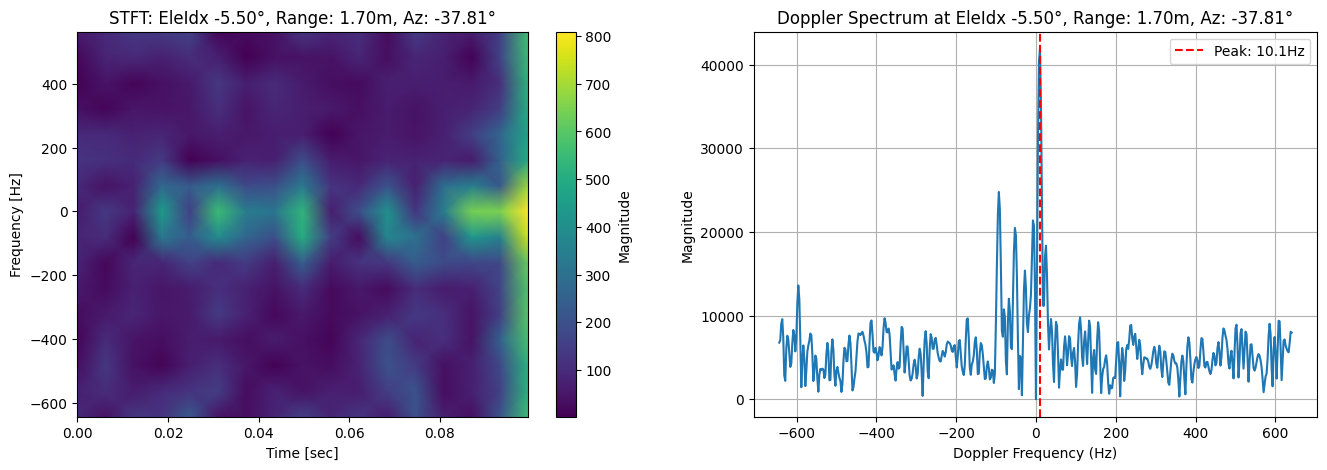

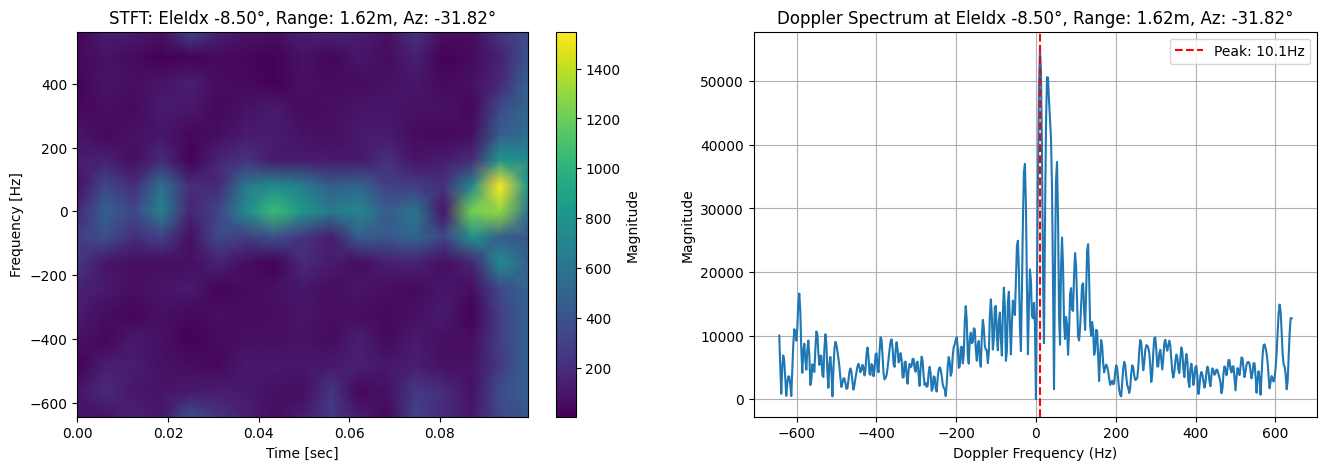

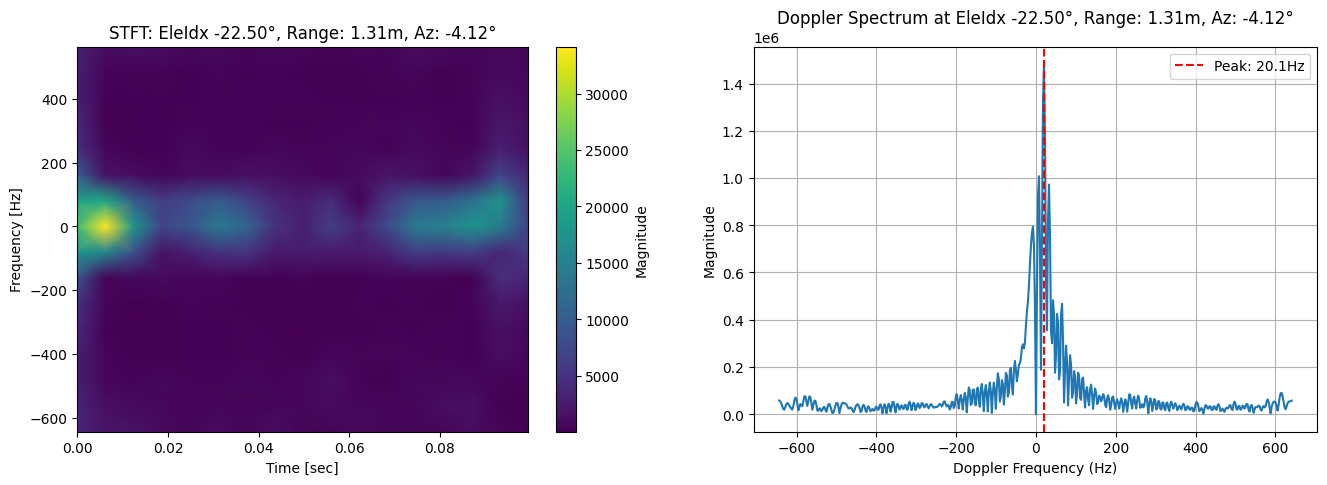

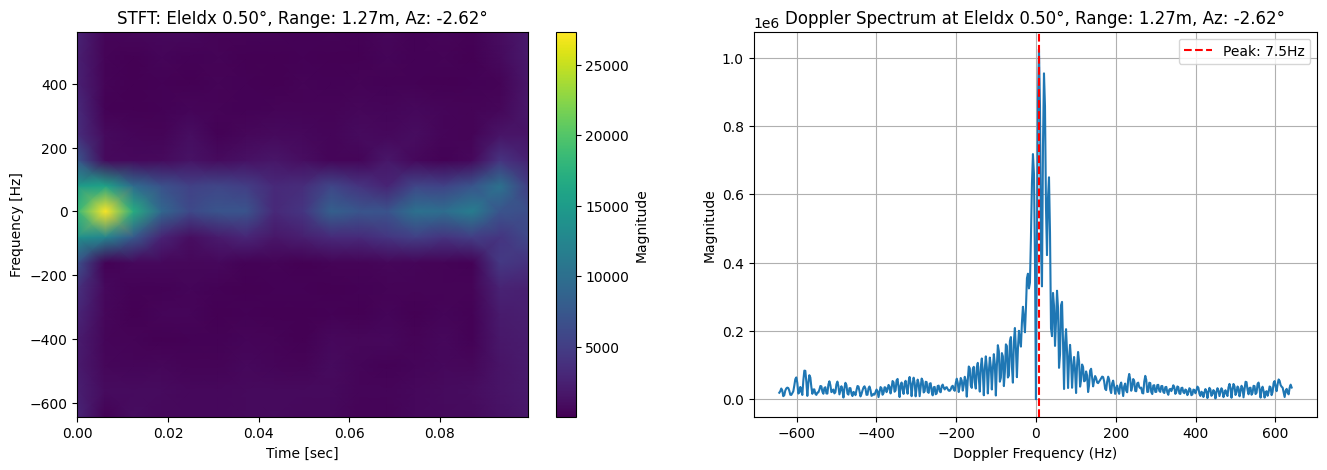

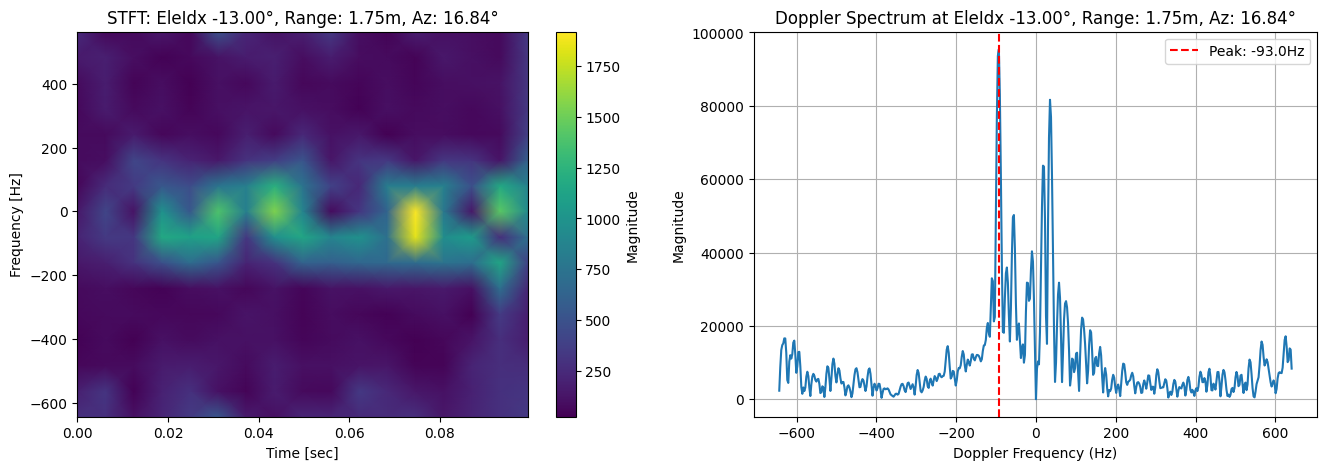

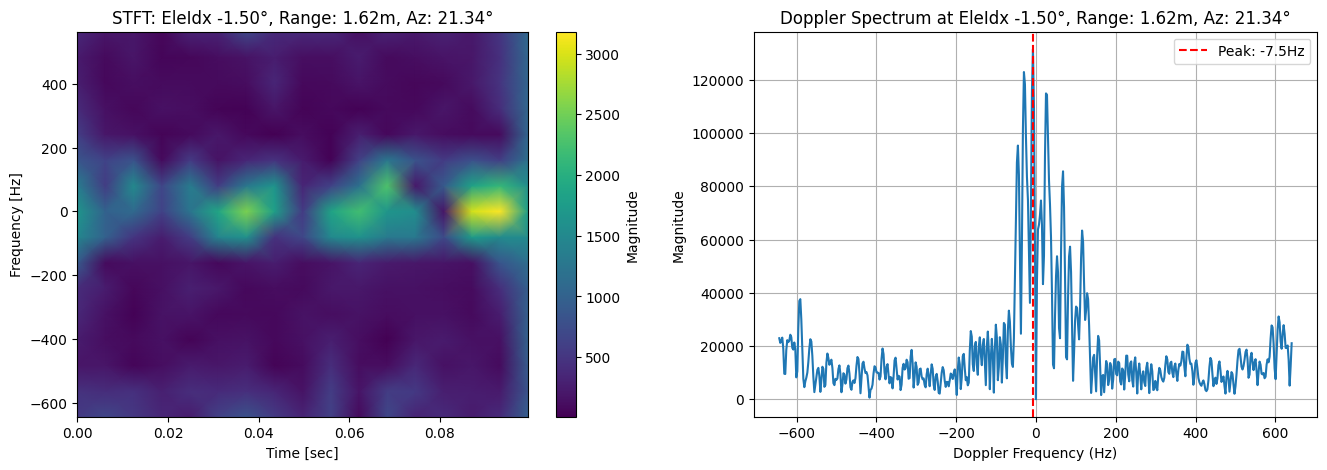

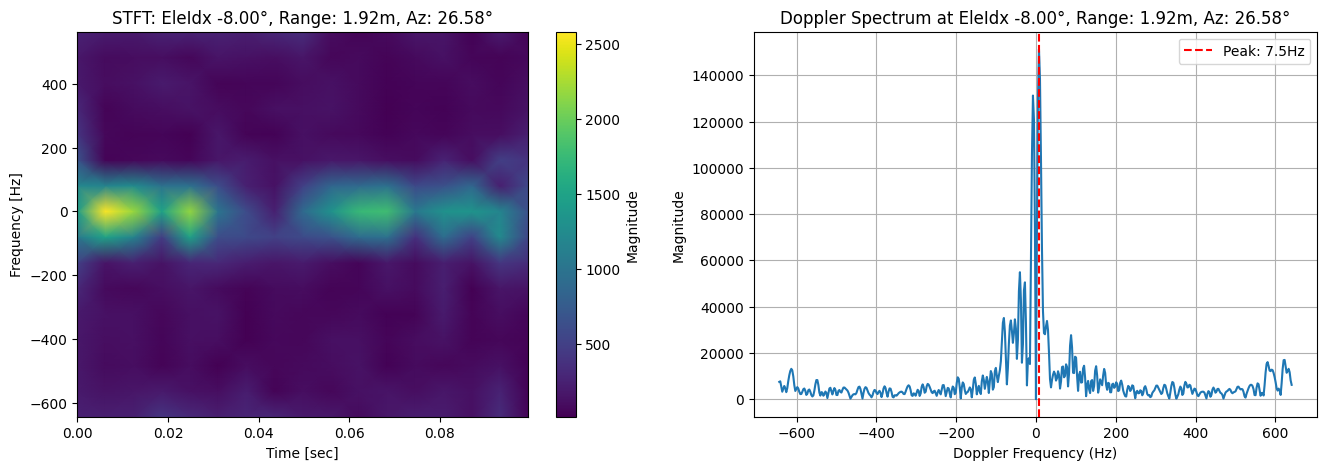

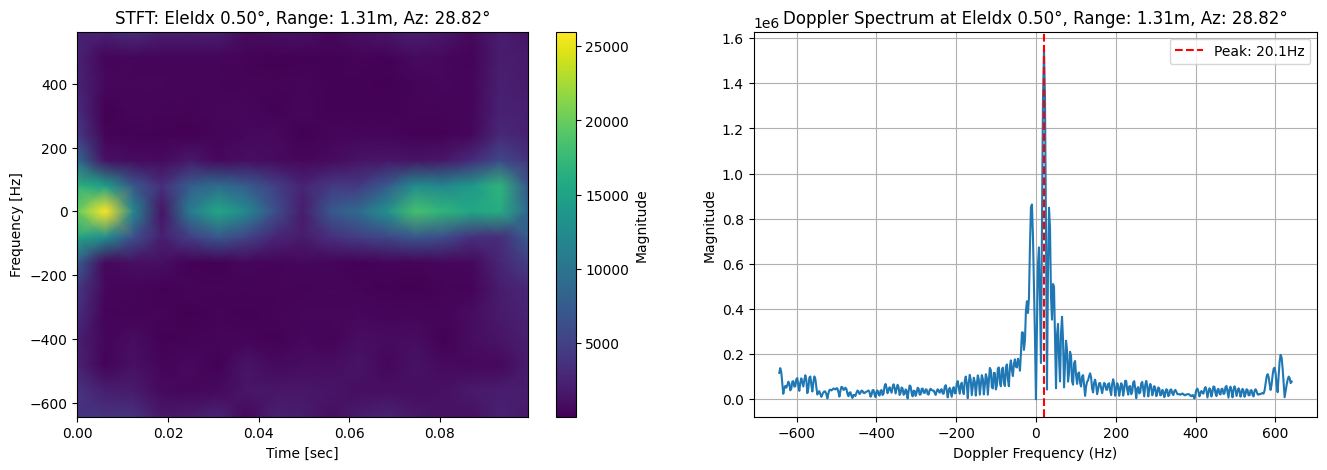

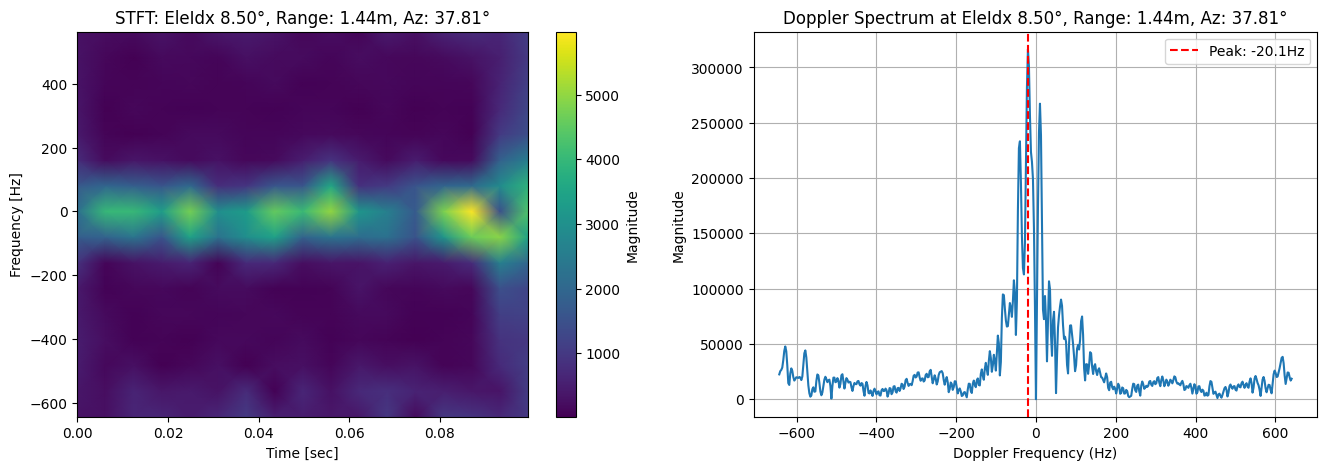

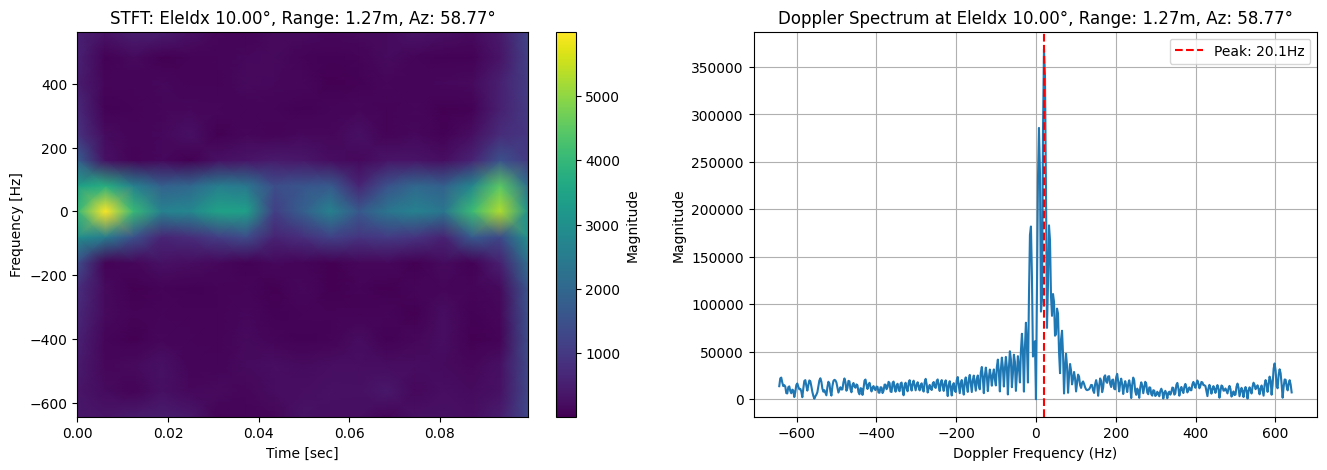

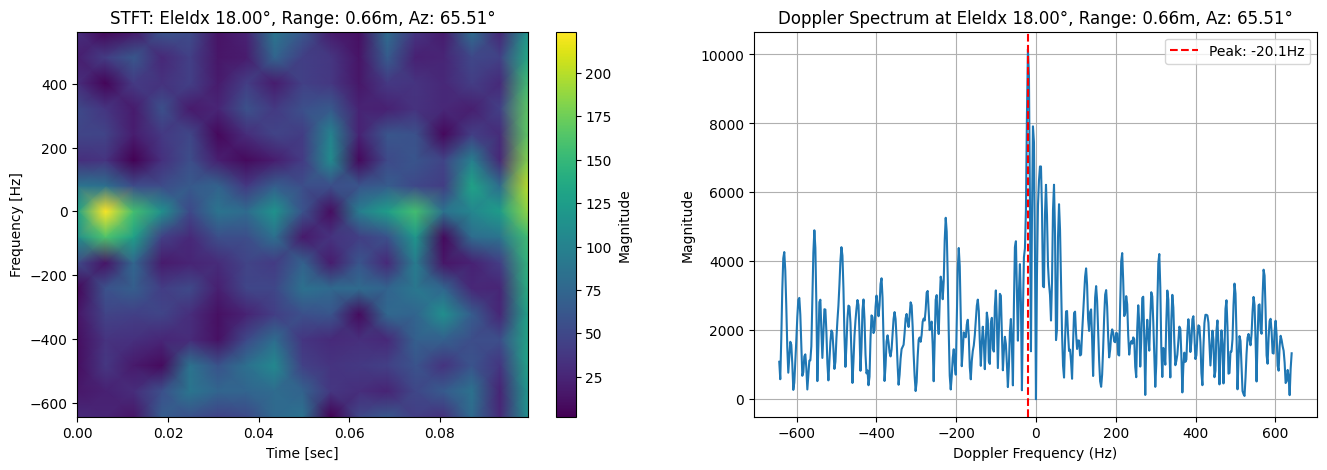

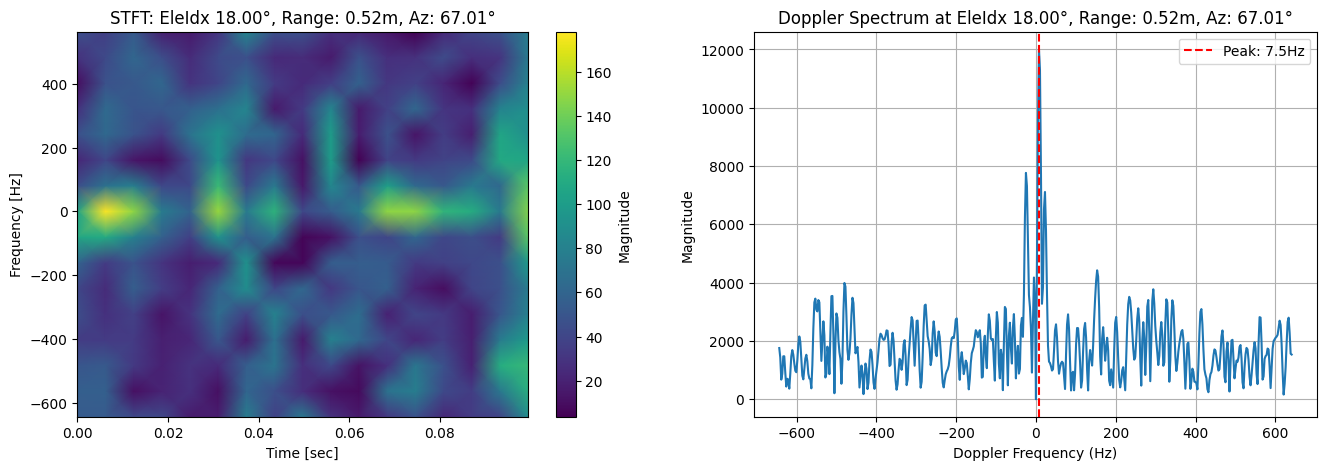

In [31]:
# Coloradar OS-CFAR
if EN_coloradar_CFAR:
    _, detections = rdsp.nq_cfar_2d(
        np.abs(range_azimuth)** 2,
        RA_OS_CFAR_WS,
        RA_OS_CFAR_GS,
        RA_OS_CFAR_K,
        RA_OS_CFAR_TOS,
    )

# openradar OS-CFAR
# --- cfar in azimuth direction
OpenRadarRAmap = np.abs(range_azimuth)** 2

first_pass, _ = np.apply_along_axis(
    func1d=dsp.cago_,
    axis=0,
    arr=OpenRadarRAmap,
    l_bound=0,
    guard_len=-1,
    noise_len=2,
)
# K < 2* noise_len
# --- cfar in range direction
second_pass, noise_floor = np.apply_along_axis(
    func1d=dsp.cago_,
    axis=0,
    arr=OpenRadarRAmap.T,
    l_bound=0,
    guard_len=-1,
    noise_len=2,
)
# --- classify peaks and caclulate snrs
noise_floor = noise_floor.T
first_pass = (OpenRadarRAmap > first_pass)
second_pass = (OpenRadarRAmap > second_pass.T)
peaks = (first_pass & second_pass)
peaks[:CFAR_SKIP_AZIMUTH_BIN, :] = 0
peaks[-CFAR_SKIP_AZIMUTH_BIN:, :] = 0
peaks[:, :CFAR_SKIP_RANGE_BIN_NEAR] = 0
peaks[:, -CFAR_SKIP_RANGE_BIN_FAR:] = 0
pairs = np.argwhere(peaks)
azimuths_idx, ranges_idx = pairs.T
snrs = OpenRadarRAmap[azimuths_idx, ranges_idx] / noise_floor[azimuths_idx, ranges_idx]
## all detections are in pairs

'''3D pcd'''
abins = AZ_MESH
ebins = EL_MESH
rbins, vbins = get_bins(RAmap_log.shape[1], Nc)
pcl = []
from core.utils.radardsp import ObjectDetected
detections: list[ObjectDetected] = []
num_ant = 12
idx_detection = 0
for xidx, yidx in pairs:
    obj = ObjectDetected()
    obj.aidx = xidx
    obj.ridx = yidx
    obj.snr = snrs[idx_detection]
    idx_detection += 1
    detections.append(obj)

# Process for each detection to estimate elevation and doppler
for idx, obj in enumerate(detections):
    obj.range = rbins[obj.ridx]
    obj.az = abins[obj.aidx]

    # estimate elevation by beamforming
    # Extract range data in the range bin [elevation, azimuth, velocity, range]
    elevation_raw = _rfft_full[:, :, :, obj.ridx]


    # num_vec = EL_BINS
    # num_vec = int(round(num_vec))
    steering_vectors_el = np.zeros((EL_BINS_NUM, num_ant), dtype='complex128') # shape: (101, 12)
    for eidx in range(EL_BINS_NUM):
        ele_rad = ebins[eidx]
        A_steering = rdsp.steering_matrix( # TODO: check the elevation!
        calibration_antenna_txl,
        calibration_antenna_rxl,
        obj.az,
        ele_rad,
        2 * calibration_d
        )
        # append A_steering to the steering_vectors_el
        steering_vectors_el[eidx, :] = A_steering.T
    
    '''elevation'''
    part1 = elevation_raw[0, 0:4, :]
    part2 = elevation_raw[1, 2:6, :]
    part3 = elevation_raw[0, 4:8, :]
    final_matrix = np.concatenate([part1, part2, part3], axis=0) # shape: (12, 128), attennas x chirps

    # ae_beamWeights = np.zeros((num_ant, EL_BINS_NUM , 1), dtype=np.complex_)
    # azimuth_elevation = np.zeros((EL_BINS_NUM, 1))


    '''Capon + QR'''
    azimuth_elevation, ae_beamWeights = dsp.aoa_capon(final_matrix, steering_vectors_el, magnitude=True, qr=True)

    det_matrix = np.abs(azimuth_elevation) # shape: (101, 1)

    thresholdElevation, noiseFloorElevation = np.apply_along_axis(func1d=dsp.cago_,
                                                axis=0,
                                                arr=(det_matrix),
                                                l_bound=0,
                                                guard_len= -1,
                                                noise_len= 2)

    det_ele_mask = (det_matrix > thresholdElevation)

    noise_power = np.percentile(det_matrix, 20)

    det_ele_mask[0:EL_CFAR_SKIP_BIN] = 0
    det_ele_mask[-EL_CFAR_SKIP_BIN:] = 0

    final_det_ele_mask = det_ele_mask & (det_matrix > noise_power * 1)
    ele_final = np.argwhere(final_det_ele_mask == True)
    ele_final = ele_final.flatten() 
    # print(np.max(ele_final))
    original_az = obj.az
    for idx in ele_final:
        obj.az = original_az
        obj.el = ebins[idx]

        ''' skip the invalid elevation '''
        if np.sin(obj.az)**2 + np.sin(obj.el)**2 > 0.99:
            continue
        # Doppler estimation

        ''' CBF beamforming '''
        point_beamWeights = steering_vectors_el[idx, :].T.reshape(-1, 1)

        # 1. Beamform to get slow-time signal
        dopplerFFTInput = np.dot(point_beamWeights.conj().T, final_matrix)
        dopplerFFTInput = np.squeeze(dopplerFFTInput)
        
        # === CRITICAL FIX: Static Clutter Removal ===
        # Subtract the mean to remove the strong DC peak (walls, static objects)
        # This allows argmax to find the NEXT strongest peak (the moving target)
        dopplerFFTInput = dopplerFFTInput - np.mean(dopplerFFTInput)
        # ============================================

        # 2. Compute FFT (Standard Order, No Shift)
        # We use standard order so that index 0 is definitely 0 m/s
        dopplerEst = np.fft.fft(dopplerFFTInput, Nc, axis=0)
        
        # 3. Find peak index
        vidx = np.argmax(np.abs(dopplerEst))
        
        # 4. Calculate Velocity Bins manually (to ensure units are correct)
        # Re-calculate these parameters to be safe
        c = 3e8
        wavelength = c / wf_start_frequency
        # Effective time between chirps for the same TX-RX pair in TDM-MIMO
        eff_chirp_time = wf_num_tx * (wf_idle_time + wf_ramp_end_time)
        
        # Generate frequencies in standard FFT order: [0, pos..., neg...]
        freqs = np.fft.fftfreq(Nc, d=eff_chirp_time)
        freqs_shifted = np.fft.fftshift(freqs)
        # Convert to velocity: v = f * lambda / 2
        vbins_manual = freqs * wavelength / 2
        
        # 5. Map index to velocity
        obj.velocity = vbins_manual[vidx]


        if 0.5 < obj.range < 2.0:
        # === STFT Plotting for ele_final elements ===
            nperseg_stft = 16
            # Ensure nperseg is not larger than signal
            if len(dopplerFFTInput) < nperseg_stft:
                nperseg_stft = len(dopplerFFTInput)

            f_stft, t_stft, Zxx_stft = signal.stft(dopplerFFTInput, fs=1.0/eff_chirp_time, nperseg=nperseg_stft, return_onesided=False)
            
            f_stft_shifted = np.fft.fftshift(f_stft)
            Zxx_stft_shifted = np.fft.fftshift(Zxx_stft, axes=0)


            
            
            # 频谱幅度也要对应移位，并且取绝对值 (Magnitude)
            spectrum_shifted = np.fft.fftshift(np.abs(dopplerEst))
            max_val = np.max(spectrum_shifted)
            max_idx = np.argmax(spectrum_shifted)
            peak_freq = freqs_shifted[max_idx]

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
            
            # Left Plot: STFT
            im = ax1.pcolormesh(t_stft, f_stft_shifted, np.abs(Zxx_stft_shifted), shading='gouraud')
            ax1.set_title(f"STFT: EleIdx {np.rad2deg(obj.el):.2f}°, Range: {obj.range:.2f}m, Az: {np.degrees(obj.az):.2f}°")
            ax1.set_ylabel('Frequency [Hz]')
            ax1.set_xlabel('Time [sec]')
            fig.colorbar(im, ax=ax1, label='Magnitude')

            # Right Plot: Doppler Spectrum
            ax2.plot(freqs_shifted, spectrum_shifted)
            ax2.set_title(f"Doppler Spectrum at EleIdx {np.rad2deg(obj.el):.2f}°, Range: {obj.range:.2f}m, Az: {np.degrees(obj.az):.2f}°")
            ax2.set_xlabel("Doppler Frequency (Hz)")
            ax2.set_ylabel("Magnitude")
            ax2.axvline(x=peak_freq, color='r', linestyle='--', label=f'Peak: {peak_freq:.1f}Hz')
            ax2.grid(True)
            ax2.legend()


            # nperseg_stft = 16
            # # Ensure nperseg is not larger than signal
            # if len(dopplerFFTInput) < nperseg_stft:
            #     nperseg_stft = len(dopplerFFTInput)

            # f_stft, t_stft, Zxx_stft = signal.stft(dopplerFFTInput, fs=1.0/eff_chirp_time, nperseg=nperseg_stft, return_onesided=False)
            
            # f_stft_shifted = np.fft.fftshift(f_stft)
            # Zxx_stft_shifted = np.fft.fftshift(Zxx_stft, axes=0)
            
            # plt.figure(figsize=(6, 4))
            # plt.pcolormesh(t_stft, f_stft_shifted, np.abs(Zxx_stft_shifted), shading='gouraud')
            # plt.title(f"STFT: EleIdx {idx}, Range: {obj.range:.2f}m, Az: {np.degrees(obj.az):.2f}°")
            # plt.ylabel('Frequency [Hz]')
            # plt.xlabel('Time [sec]')
            # plt.colorbar(label='Magnitude')
            # plt.show()
        # ============================================

        # if 0.5 < obj.range < 2.0:
        #     freqs_shifted = np.fft.fftshift(freqs)
            
        #     # 频谱幅度也要对应移位，并且取绝对值 (Magnitude)
        #     spectrum_shifted = np.fft.fftshift(np.abs(dopplerEst))
        #     plt.figure(figsize=(10, 5)) # 建议设置一下画布大小
        #     plt.plot(freqs_shifted, spectrum_shifted)
            
        #     plt.title(f"Doppler Spectrum at EleIdx {idx}, Range: {obj.range:.2f}m, Az: {np.degrees(obj.az):.2f}°")
        #     plt.xlabel("Doppler Frequency (Hz)") # 横坐标现在是频率
        #     plt.ylabel("Magnitude")
        #     plt.grid(True) # 加网格更好看
            
        #     # 可选：标出峰值位置
        #     max_val = np.max(spectrum_shifted)
        #     max_idx = np.argmax(spectrum_shifted)
        #     peak_freq = freqs_shifted[max_idx]
        #     plt.axvline(x=peak_freq, color='r', linestyle='--', label=f'Peak: {peak_freq:.1f}Hz')
        #     plt.legend()


        obj.el = -obj.el
        obj.az = np.arcsin(np.sin(obj.az)/np.cos(obj.el))

        pcl.append(np.array([
                    obj.az,                     # Azimnuth
                    obj.range,                  # Range
                    obj.el,                     # Elevation
                    obj.velocity,               # Velocity
                    10 * np.log10(obj.snr)      # SNR
                ]))

pcl = np.array(pcl)

# Remove very close range
# pcl = pcl[pcl[:, 1] >= 1.5]
# no polar
pcl = to_cartesian(pcl) 

'''Extra step to revise the azimuth and elevation'''
pcl[:,3] = -pcl[:,3]

In [32]:
for frame_idx in range(len(radar_messages)):  # 选择要处理的帧索引
    data = np.array(radar_messages[frame_idx].data, dtype=np.int16)
    cube = convert_to_complex_cube(
        data, wf_num_chirps_per_frame, wf_num_rx, wf_num_adc_samples_per_chirp,
        is_complex = True, interleaved = True
    )
    # cube shape: [num_chirps, num_rx, num_samples]

    # 2. Reshape to TDM structure: [loops, tx, rx, samples]
    # For TDM-MIMO, chirps are interleaved by TX: TX1, TX2, TX3, TX1, TX2, TX3, ...
    # So we reshape to [loops, tx, rx, samples] where loops = num_chirps / num_tx
    if tdm_mimo:
        n_loops = wf_num_chirps_per_frame // wf_num_tx
        if wf_num_chirps_per_frame % wf_num_rx != 0:
            raise ValueError(f"num_chirps ({wf_num_chirps_per_frame}) must be divisible by num_tx ({wf_num_tx})")
        
        # Reshape: [num_chirps, num_rx, num_samples] -> [loops, tx, rx, samples]
        # The chirps are in order: TX0, TX1, TX2, TX0, TX1, TX2, ...
        tdm_cube = cube.reshape(n_loops, wf_num_tx, wf_num_rx, wf_num_adc_samples_per_chirp)
    else:
        # Non-TDM-MIMO: keep as [chirps, rx, samples]
        # Add dummy TX dimension for consistency: [chirps, 1, rx, samples]
        tdm_cube = cube[:, None, :, :]
        n_loops = wf_num_chirps_per_frame
        
    # 3. Add batch dimension: [1, loops, tx, rx, samples]
    # Process each frame independently (no buffering/concatenation)
    iq = tdm_cube[None, ...]
    # iq shape: [1, loops, tx, rx, samples]
    processing_cube = iq
    batch, doppler, tx, rx, samples = processing_cube.shape

    # 4. Apply Range-Doppler FFT (along doppler=axis 1, range=axis 4)
    # Shift only doppler axis to center zero-velocity, keep range 0 at index 0
    # This preserves the physical meaning of range bins (0 = closest to radar)
    rd = fft_with_shift(processing_cube, axes=(1, 4), shift=(1,))
    # rd shape: [batch, doppler, tx, rx, range]

    # 5. Construct virtual array from physical antenna data
    # For TDM-MIMO: Maps 3 TX × 4 RX physical antennas to 2 elevation × 8 azimuth virtual array
    # For non-TDM-MIMO: Use simple virtual array (1 elevation, num_rx azimuth)
    if tdm_mimo:
        mimo = construct_virtual_array(rd)
    else:
        # Non-TDM-MIMO: simple virtual array (no elevation/azimuth separation)
        # Use first TX antenna data (or all TX if only one)
        batch, doppler, tx, rx, range_bins = rd.shape
        # For non-TDM-MIMO, we typically have only one TX active
        # Create virtual array: [batch, doppler, 1, rx, range]
        mimo = rd[:, :, 0:1, :, :]  # Use first TX only
        # Reshape to match expected shape [batch, doppler, elevation, azimuth, range]
        # Add elevation dimension: [batch, doppler, 1, rx, range]
        mimo = mimo.reshape(batch, doppler, 1, rx, range_bins)
    # mimo shape: [batch, doppler, elevation, azimuth, range]

    # 6. Apply Elevation-Azimuth FFT (along elevation=axis 2, azimuth=axis 3)
    # Zero-pad azimuth dimension to 128 for higher angular resolution
    # Shift both elevation and azimuth axes to center zero-angle
    azimuth_size = 128  # Target azimuth resolution
    elevation_size = mimo.shape[2]  # Keep original elevation size
    raw = np.transpose(tdm_cube, (1, 2, 0, 3))  # [batch, loops, rx, tx, samples]

    # Remove DC bias and calibrate the raw data
    adc_samples = dc_remove(raw)
    # ntx: Number of TX antenna
    # nrx: Number of RX antenna
    # nc: Number of chirp per antenna in the virtual array
    # ns: Number of samples per chirp
    # ntx, nrx, nc, ns = adc_samples.shape
    _, _, Nc, Ns = get_fft_size(None, None, wf_num_chirps_per_frame, wf_num_adc_samples_per_chirp)

    # Range-FFT
    rfft = np.fft.fft(adc_samples * np.blackman(wf_num_adc_samples_per_chirp).reshape(1, 1, 1, -1), Ns, -1)

    '''NO clutter removal applied, since static objects are also considered'''

    # Adjust original signal to the virtual array [Elevation channel: 2, Azimuth channel: 8, CHIRP: 128, SAMPLES: 128]
    _rfft_full = pre_process(rfft, apply_padding=False) # No padding applied, which affects the covariance matrix

    _rfft = _rfft_full[0, :, :, :]

    # swith first and second dimension into (num_chirps_per_frame, num_azimuth_channels, num_range_bins)
    _rfft = np.swapaxes(_rfft, 0, 1)

    BINS_PROCESSED_RANGE = _rfft.shape[2] # num_range_bins: sample number in one chirp, also the number of range bins
    AZ_CHANNELS = _rfft.shape[1]  # num_azimuth_channels: number of virtual azimuth channels


    # -------------------------------------------------------------------------
        # [Frequency Calibration]
        # Calculate the "Normalized Antenna Spacing" at the current Chirp's center frequency.
        #
        # 1. Calculate Center Frequency:
        #    f_center = f_start + (Slope * Sample_Time) / 2
        #    This represents the average frequency during the chirp sweep.
        #
        # 2. Calculate the ratio of physical distance to actual wavelength (d / lambda):
        #    Given: Physical spacing d_phys is fixed at the halp wavelength under the designed frequency (0.5 * lambda_design).
        #    Formula: calibration_d = d_phys / lambda_actual
        #                      = (0.5 * c / f_design) / (c / f_center)
        #                      = 0.5 * (f_center / f_design)
        #
        # [IMPORTANT NOTE]
        # The actual unit is [Multiples of Wavelength] (e.g., ~0.5), not meters.
        # This step calibrates phase errors caused by the operating frequency deviating
        # from the hardware design frequency.
        # -------------------------------------------------------------------------
    calibration_d = 0.5 * ((wf_start_frequency + (wf_frequency_slope * stime) / 2) / fdesign)


    # using OpenRadar DSP library
    num_vec, steering_vec = dsp.gen_steering_vec(AZ_MAX, ANGLE_RES_AZ, AZ_CHANNELS,
                                                #  1)
                                                    2 * calibration_d) # 8 antennas in azimuth, 2 * calibration_d refers to the normalized antenna spacing (always *2 as th param)
    range_azimuth = np.zeros((AZ_BINS_NUM, BINS_PROCESSED_RANGE))

    range_azimuth_CBF = np.zeros((_rfft.shape[0], AZ_BINS_NUM, BINS_PROCESSED_RANGE))# only used for visualization in chirp rate

    # NOTE: WILL BE OPTIMIZED TO MATRIX OPERATION
    for i in range(BINS_PROCESSED_RANGE):
        if method == 'Capon':
            range_azimuth[:,i], _ = dsp.aoa_capon(_rfft[:, :, i].T, steering_vec, magnitude=True)
        elif method == 'Bartlett':
            range_azimuth_multi = dsp.aoa_bartlett(steering_vec, _rfft[:, :, i], axis =1)
            range_azimuth_CBF[:,:,i] = range_azimuth_multi # only used for visualization in chirp rate
            range_azimuth[:,i] = np.abs(range_azimuth_multi.sum(0)).squeeze()
    ## in dB, TODO: check if this is correct in cascade radar

    RAmap_log = 20*np.log10(np.abs(range_azimuth))
    RAmap_sq = np.abs(range_azimuth)** 2 # [Azimuth, Range]
    RAmap = RAmap_log**6
    Nr = RAmap.shape[1]
    abins = AZ_MESH
    ebins = EL_MESH
    rbins, vbins = get_bins(RAmap_log.shape[1], Nc)
    polar=False
    show=True
    # ...existing code...
    RAmap = np.transpose(RAmap, (1, 0))

    # # 只绘制 5 米以内的热图
    # range_limit = 4.0
    # range_mask = rbins <= range_limit
    # if not np.any(range_mask):
    #     raise ValueError(f"No range bins <= {range_limit} m (max range = {rbins.max():.2f} m)")

    # # 保留对应的行并更新 rbins
    # RAmap = RAmap[range_mask, :]
    # rbins = rbins[range_mask]

    if not polar:
        # 非极坐标绘制：用 meshgrid 对应 (azimuth, range)
        az, rg = np.meshgrid(abins, rbins)
        fig, ax = plt.subplots()
        RAmap_plot = np.fliplr(RAmap)
        color = ax.pcolormesh(az, rg, RAmap_plot, cmap="viridis")
        ax.set_xlabel("Azimuth (rad)")
    else:
        # 极坐标风格：将矩阵展平后 scatter（s 可调以控制点大小）
        RAmap_plot = np.fliplr(RAmap)
        _r = np.kron(rbins, np.cos(abins)).flatten()
        _az = np.kron(rbins, np.sin(abins)).flatten()
        vals = RAmap_plot.flatten()
        ax = plt.axes()
        sc = ax.scatter(_az, _r, c=vals, cmap="viridis", s=1)
        ax.set_xlabel("Azimuth (m)")
        ax.set_facecolor("black")

    # ax.tick_params(axis='both', which='both',
    #     bottom=False, top=False, left=False, right=False,
    #     labelbottom=False, labeltop=False, labelleft=False, labelright=False)

    ax.set_ylabel("Range (m)")
    if show:
        # plt.show()
        # print(frame_idx)
        plt.savefig(f"./static_01/radar_plots_frame_{frame_idx}.png")
    plt.close()    
    # ...existing code...

In [30]:
rbins.shape
RAmap_log.shape

(188, 128)